# Calibración y análisis — Modelo de Tanques

## 1. Carga y preparación de datos

In [ ]:

import pandas as pd
import numpy as np
from tank_model import TankModel, ModelConfig, nse, kge, bias_pct
from tank_model.parameters import Parameters
from tank_model.io import load_csv, subset_period, tag_hydrology, ensure_pet_coverage
from tank_model.et import ensure_pet
import matplotlib.pyplot as plt

# Cargar datos de prueba (1950-2017)
df = load_csv('../data/Datos_prueba_2.csv')
df.head()

,Afluente_SN,a,b,Temp_C,Qobs_m3s,P_mm,PET_mm
date,,,,,,,
1950-01-01,0.8,NaN,NaN,18.46,2.193,0.8,3.252
1950-01-02,0.0,NaN,NaN,18.46,1.108,0.0,3.252
1950-01-03,0.0,NaN,NaN,18.46,1.086,0.0,3.252
1950-01-04,0.0,NaN,NaN,18.46,1.064,0.0,3.252
1950-01-05,0.0,NaN,NaN,18.46,1.043,0.0,3.252


In [9]:
# Seleccionar método de PET (opciones: 'column', 'cenicafe', 'hargreaves')
pet_method = 'column'  # lectura de PET desde la tabla


<Axes: title={'center': 'P y PET'}, xlabel='date'>

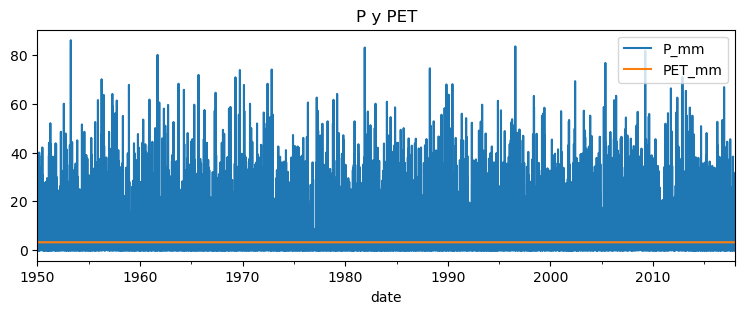

In [10]:
# Asegurar PET
required = {
    'column': ['PET_mm'],
    'cenicafe': ['Tmean_C', 'Rs_MJ_m2_d'],
    'hargreaves': ['Tmean_C', 'Tmax_C', 'Tmin_C', 'Ra_MJ_m2_d'],
}
if pet_method == 'cenicafe':
    df_med = load_csv('../data/medellin_pet_inputs.csv')
    df_med_pet = ensure_pet(df_med, method='cenicafe', a=0.0135, b=17.78)
    df['PET_mm'] = df_med_pet['PET_mm'].reindex(df.index)
else:
    missing = [c for c in required.get(pet_method, []) if c not in df.columns]
    if missing:
        print(f'Se omite ensure_pet: faltan columnas {missing}')
    else:
        df = ensure_pet(df, method=pet_method)

df[['P_mm','PET_mm']].plot(title='P y PET', figsize=(9,3))


In [11]:
# Dividir serie en calibración y validación
calib_frac = 0.7  # proporción de datos para calibración
split_date = None  # e.g., '1980-12-31' para dividir por fecha

if split_date:
    df_calib = df.loc[:split_date]
    df_valid = df.loc[split_date:]
else:
    split_idx = int(len(df) * calib_frac)
    df_calib = df.iloc[:split_idx]
    df_valid = df.iloc[split_idx:]
# número de filas para calibración (útil más adelante)
split_idx = len(df_calib)


## 2. Configuración del modelo y simulación inicial


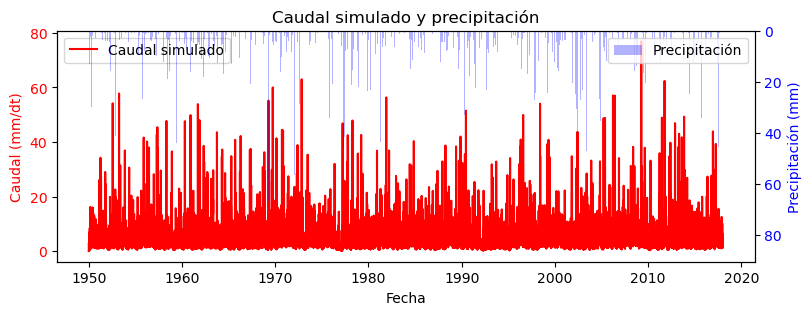

In [35]:

# Configurar y correr
cfg = ModelConfig(dt_hours=24.0, area_km2=0.173, route=True)  # área de cuenca 0.173 km²
p = Parameters()
m = TankModel(p, cfg)
sim = m.run(df)
#sim[['Qout_mm']].plot(title='Qout (mm/dt)', figsize=(9,3))

# Graficar el caudal simulado junto con la precipitación

fig, ax1 = plt.subplots(figsize=(9,3))
ax2 = ax1.twinx()
# Caudal simulado en mm/dt: color rojo
ax1.plot(df.index, sim['Qout_mm'], color='red', label='Caudal simulado')
# Precipitación: barras azules
ax2.bar(df.index, df['P_mm'], color='blue', alpha=0.3, label='Precipitación')
ax1.set_ylabel('Caudal (mm/dt)', color='red')
ax2.set_ylabel('Precipitación (mm)', color='blue')
ax2.invert_yaxis()
ax1.set_xlabel('Fecha')
ax1.set_title('Caudal simulado y precipitación')
ax1.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='blue')
# Mostrar leyendas de ambos ejes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


## 3. Calibración de parámetros
A continuación se muestra cómo registrar una calibración en el archivo de log y consultar las últimas calibraciones registradas para una cuenca.

Mejor NSE registrado: 0.896
NSE en validación: 0.8938006779234011
Últimas calibraciones registradas:   id            timestamp       catchment               score  \
0  1  2025-08-26T16:15:02  Test_catchment  0.8961232085126564   
1  0  2025-08-26T13:48:51  Test_catchment  0.8976432867023724   

              S0_max             alpha                beta  \
0  80.68036234508456  1.69306573307467  1.1527447610345614   
1  80.68036234508456  1.69306573307467  1.1527447610345614   

                  k_qs                k_inf               k_perc  \
0  0.08106198126015492  0.14330192904898237  0.04012358465409101   
1  0.08106198126015492  0.14330192904898237  0.04012358465409101   

                  phi                k_qf                  k_bf  \
0  0.6617468438860865  0.2215658400667005  0.044465227941883075   
1  0.6617468438860865  0.2215658400667005  0.044465227941883075   

                  f_et0                f_et1 n_r                k_r  id_num  
0  0.006867369651729605  0.0981

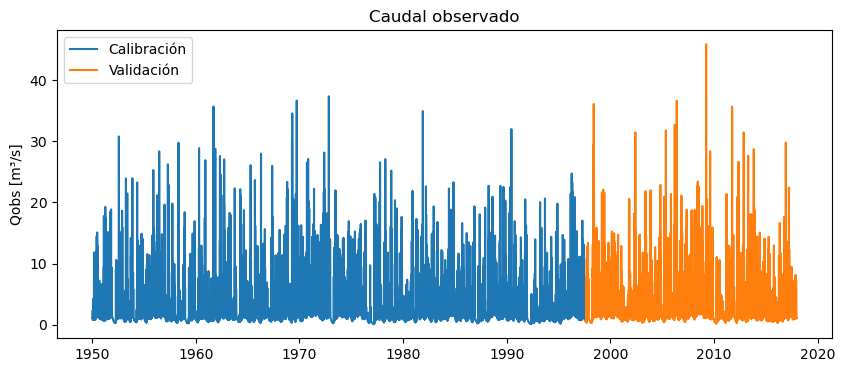

In [ ]:
# Registrar calibración en el log y listar calibraciones recientes
from tank_model.calibration import random_search, list_recent_calibrations

def make_model(p):
    return TankModel(params=p, config=cfg)

# Serie observada sintética basada en la simulación previa
q_obs = sim['Q_m3s'].values * (1 + np.random.normal(0, 0.1, size=len(sim)))
q_obs_calib = q_obs[:split_idx]
q_obs_valid = q_obs[split_idx:]

# Nombre de la cuenca para registrar la calibración
catchment_name = 'Test_catchment'
log_path = f'../data/calibration_log.csv'

# Ejecutar búsqueda aleatoria y guardar en el log
best_p, best_score = random_search(
    make_model,
    df_calib,
    q_obs_calib,
    n_iter=20,
    seed=123,
    catchment_name=catchment_name,
    log_path=log_path,
)
print(f'Mejor NSE registrado: {best_score:.3f}')

# Evaluar con la serie de validación
model_val = make_model(best_p)
sim_val = model_val.run(df_valid)
print('NSE en validación:', nse(q_obs_valid, sim_val['Q_m3s'].values))

# Listar las 5 últimas calibraciones para esta cuenca
df_recent = pd.DataFrame(list_recent_calibrations(catchment_name, n=5, log_path=log_path))
print('Últimas calibraciones registradas:')
print(df_recent)





In [ ]:
# Graficar caudal observado para calibración y validación\n",
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df_calib.index, df_calib['Qobs_m3s'], label='Calibración')
ax.plot(df_valid.index, df_valid['Qobs_m3s'], label='Validación')
ax.set_ylabel('Qobs [m³/s]')
ax.legend()
ax.set_title('Caudal observado')
plt.show()

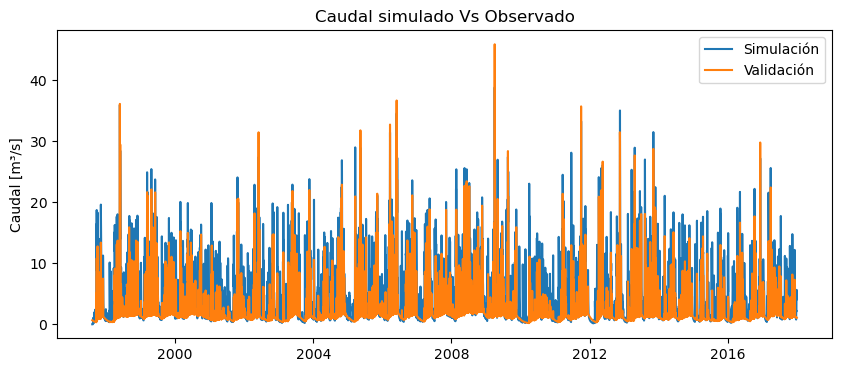

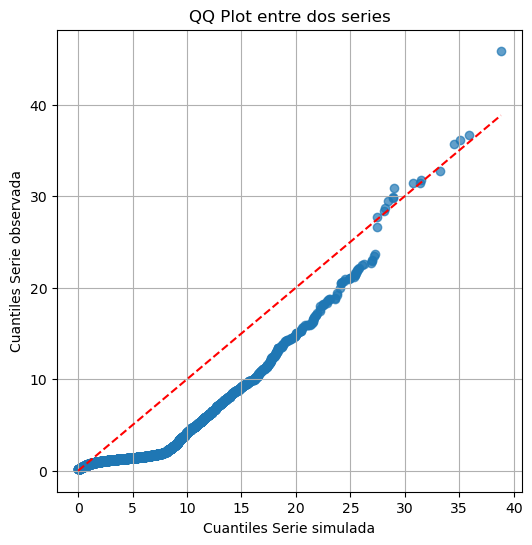

In [27]:
# Graficar caudal simulado y validación\n",
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(sim_val.index, sim_val['Qout_mm'], label='Simulación')
ax.plot(df_valid.index, df_valid['Qobs_m3s'], label='Validación')
ax.set_ylabel('Caudal [m³/s]')
ax.legend()
ax.set_title('Caudal simulado Vs Observado')
plt.show()

# Ordenar las dos series y emparejar por percentiles
q1 = np.quantile(sim_val['Qout_mm'], np.linspace(0, 1, len(sim_val['Qout_mm'])))
q2 = np.quantile(df_valid['Qobs_m3s'], np.linspace(0, 1, len(df_valid['Qobs_m3s'])))

# Graficar QQ-plot
plt.figure(figsize=(6,6))
plt.scatter(q1, q2, alpha=0.7)
plt.plot([q1.min(), q1.max()], [q1.min(), q1.max()], 'r--')  # línea 1:1
plt.xlabel("Cuantiles Serie simulada")
plt.ylabel("Cuantiles Serie observada")
plt.title("QQ Plot entre dos series")
plt.grid(True)
plt.show()

## 4. Simulación con calibración guardada
Aplicar una calibración guardada a un conjunto de forzantes distinto.

<Axes: title={'center': 'Caudal simulado con calibración guardada en nuevos forzantes'}, xlabel='date'>

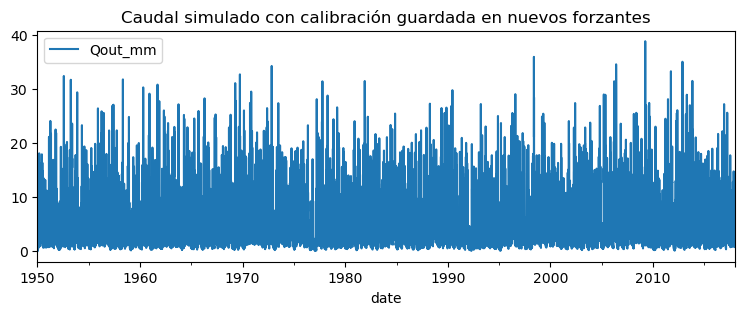

In [ ]:
# Aplicar la calibración guardada a nuevos forzantes
# Cambiar Datos_prueba_2.csv con los nuevos datos de precipitación, temperatura y/o evapotranspiracion
df_new = load_csv('../data/Datos_prueba_2.csv') 
from tank_model.calibration import run_with_saved_calibration

# Asegurar PET en df_new
df_new = ensure_pet_coverage(df_new, df['PET_mm'])

# Ejecutar el modelo con la última calibración registrada (ID por defecto)
sim_new = run_with_saved_calibration(make_model, df_new, catchment_name=catchment_name, log_path=log_path)

sim_new[['Qout_mm']].plot(title='Caudal simulado con calibración guardada en nuevos forzantes', figsize=(9,3))


## 5. Análisis


In [33]:

# Análisis seco/húmedo y métricas por régimen
reg = tag_hydrology(df, col='P_mm', dry_q=0.25, wet_q=0.75)
sim['regime'] = reg
sim.groupby('regime')['Qout_mm'].describe()


,count,mean,std,min,25%,50%,75%,max
regime,,,,,,,,
dry,6214.0,1.258236,0.461584,0.031788,0.923045,1.218164,1.555891,3.145682
normal,12413.0,4.005097,1.856636,0.523339,2.571751,3.616812,5.096943,11.966173
wet,6210.0,10.116794,5.917783,1.675618,6.764927,8.951504,11.646585,76.898805


In [34]:

# NSE/KGE por subperíodos (ejemplo sintético con obs = sim + ruido)
obs = sim['Qout_mm'] * (1 + np.random.normal(0, 0.1, size=len(sim)))
print('NSE total:', nse(obs, sim['Qout_mm']))
for r in ['dry','normal','wet']:
    mask = sim['regime'] == r
    print(r, 'NSE=', nse(obs[mask], sim.loc[mask,'Qout_mm']))


NSE total: 0.9792490687533324
dry NSE= 0.9236776686761906
normal NSE= 0.9477343135918626
wet NSE= 0.9620800635817607


## 6. Comparación de caudales

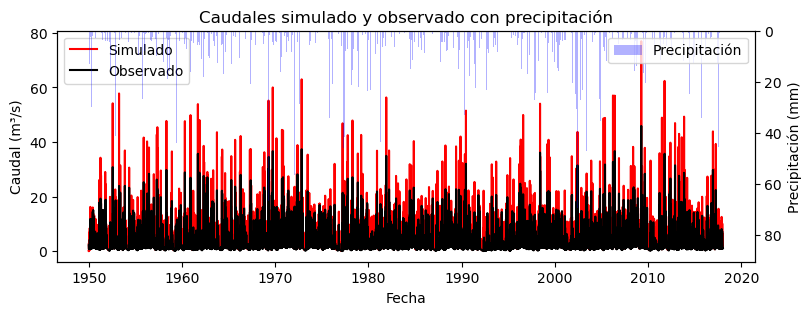

In [ ]:

# Comparación caudal simulado vs observado
df_obs = load_csv('../data/Datos_prueba_2.csv')
# Asegurar que la columna se llame 'Qobs_m3s'
if 'Qobs_m3s' not in df_obs.columns:
    raise ValueError('La columna Qobs_m3s no se encuentra en Datos_prueba_2.csv')
# Unir las series por fecha y graficar
comp = sim[['Qout_mm']].join(df_obs['Qobs_m3s'].rename('Qobs_m3s'), how='inner')
# Extraer precipitación en las mismas fechas
df_precip = df.loc[comp.index, ['P_mm']]

fig, ax1 = plt.subplots(figsize=(9,3))
ax2 = ax1.twinx()
ax1.plot(comp.index, comp['Qout_mm'], color='red', label='Simulado')
ax1.plot(comp.index, comp['Qobs_m3s'], color='black', label='Observado')
# Precipitación en el eje secundario (convertir a mm si es necesario)
ax2.bar(df_precip.index, df_precip['P_mm'], color='blue', alpha=0.3, label='Precipitación')
ax2.invert_yaxis()
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Caudal (m³/s)')
ax2.set_ylabel('Precipitación (mm)')
ax1.set_title('Caudales simulado y observado con precipitación')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

### Curvas de duración de caudales

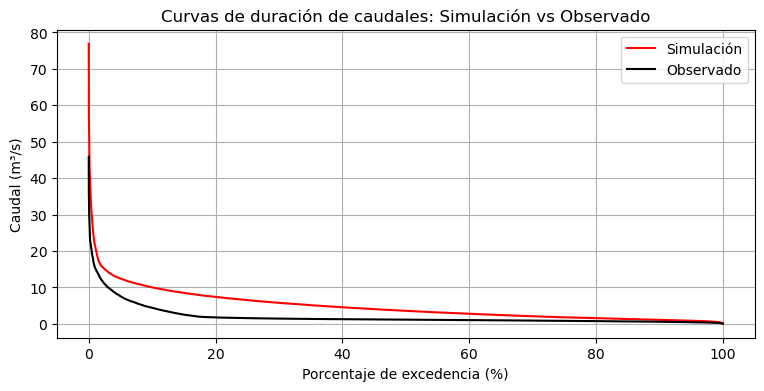

In [ ]:

# Curvas de duración de caudales (FDC) comparando simulación y observación

# Asegurarse de que existe el DataFrame 'comp'
if 'comp' not in globals():
    df_obs = load_csv('../data/Datos_prueba_2.csv')
    comp = sim[['Qout_mm']].join(df_obs['Qobs_m3s'].rename('Qobs_m3s'), how='inner')

# Preparar datos de FDC
flows_sim = comp['Qout_mm'].dropna().values
sorted_sim = np.sort(flows_sim)[::-1]
exceedance_sim = np.arange(1, len(sorted_sim)+1) / (len(sorted_sim)+1)

flows_obs = comp['Qobs_m3s'].dropna().values
sorted_obs = np.sort(flows_obs)[::-1]
exceedance_obs = np.arange(1, len(sorted_obs)+1) / (len(sorted_obs)+1)

plt.figure(figsize=(9,4))
plt.plot(exceedance_sim * 100, sorted_sim, color='red', label='Simulación')
plt.plot(exceedance_obs * 100, sorted_obs, color='black', label='Observado')
plt.xlabel('Porcentaje de excedencia (%)')
plt.ylabel('Caudal (m³/s)')
plt.title('Curvas de duración de caudales: Simulación vs Observado')
plt.legend()
plt.grid(True)
plt.show()